In [85]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [86]:
import sys

import numpy as np
import matplotlib.pyplot as plt
#from logs import enable_logging, logging 
from importlib import reload
import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

net = nn.Sequential(
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
)


# Set the optimizer, you have to play with lr: if too big nan
optim = torch.optim.SGD(net.parameters(), lr = 1e-6)
##optim = torch.optim.Adadelta(net.parameters())
#optim = torch.optim.Adam(net.parameters(), lr=1e-6)
#optim = torch.optim.ASGD(net.parameters())
# SGD seems much faster

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[-0.2992,  0.3257, -0.2604],
          [ 0.1558, -0.2104, -0.2195],
          [-0.2171, -0.0021,  0.0108]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.1266, -0.2485,  0.1651],
          [-0.0218,  0.2788, -0.1038],
          [-0.1612, -0.2442, -0.0046]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.1638,  0.2232, -0.1772],
          [-0.0397,  0.1054,  0.0481],
          [-0.0194, -0.0955, -0.1199]]]], requires_grad=True)


In [88]:
class dirichlet_problem:
    """A class for setting a problem instance"""
    
    def __init__(self, B_idx=None, B=None, forcing_term=None, k=20, k_ground_truth = 1000, initial_u=None, domain_type="Square", N=16):
        
        if B_idx is None:
            self.B_idx, self.B = geometries.square_geometry(N)
        else:
            self.B_idx = B_idx
            self.B = B
            
        if forcing_term is None:
            self.forcing_term = torch.zeros(1, 1, N, N)
        else:
            self.forcing_term = forcing_term
        
        if initial_u is None:
            self.initial_u = torch.rand(1, 1, N, N, requires_grad=True)
        else:
            self.initial_u = initial_u
        
        self.k = k 
        
        # Initial_u_jacobi is different, it must not require grad
        self.initial_u_jacobi = torch.zeros(1, 1, N, N)
        self.k_ground_truth = k_ground_truth
        self.ground_truth = im.jacobi_method(self.B_idx, self.B, self.forcing_term, self.initial_u_jacobi, self.k_ground_truth)


In [89]:
def compute_loss(net, problem_instances_list):
    """ Fucntion to compute the total loss given a set of problem instances"""
    
    loss = torch.zeros(1, requires_grad = False)
    u = torch.zeros(1, 1, N, N, nb_problem_instances)
    
    for problem_instance in problem_instances_list:

        B_idx = problem_instance.B_idx
        B = problem_instance.B
        f = problem_instance.forcing_term
        initial_u = problem_instance.initial_u
        k = problem_instance.k
        ground_truth = problem_instance.ground_truth
        
        u = im.H_method(net, B_idx, B, f, initial_u, k)
        loss = loss + F.mse_loss(ground_truth, u)
        
    return loss

In [90]:
class train_iterativeMethod:
    """A class to obtain the optimal weights"""
    def __init__(self, net, problem_instances_list, batch_size=1, learning_rate = 1e-6,max_iters = 1000, tol = 1e-6, k_range = [1, 20]):
        
        self.net = net
        self.learning_rate = learning_rate
        optim = torch.optim.SGD(net.parameters(), learning_rate)

        self.batch_size = batch_size
        self.max_iters = max_iters
        self.tol = tol
        self.k_range = k_range
        
        self.problem_instances_list = problem_instances_list
        self.nb_problem_instances = len(problem_instances_list)
        
    def _optimization_step_(self):
            net.zero_grad()
            loss = torch.zeros(1)

            u_list = [None] * self.batch_size

            # Sample problem_instances
            problem_idx = np.random.choice(np.arange(self.nb_problem_instances), self.batch_size, replace = 0)

            for i in range(self.batch_size):

                idx = problem_idx[i]
                problem_instance = self.problem_instances_list[idx]

                B_idx = problem_instance.B_idx
                B = problem_instance.B
                f = problem_instance.forcing_term
                initial_u = problem_instance.initial_u
                k = problem_instance.k
                ground_truth = problem_instance.ground_truth

                # Compute the solution with the updated weights      
                u_list[i] = im.H_method(net, B_idx, B, f, initial_u, k)

                # Define the loss, CHECK if it is correct wrt paper
                loss = loss + F.mse_loss(ground_truth, u_list[i])
                
                # Backpropagation
                loss.backward(retain_graph =  False)

                # SGD step
                optim.step()
                
                """ TODO: add check on spectral radius"""
                
    def _optimal_weights_(self):
        losses = []
        prev_total_loss = 0 
        #print(prev_total_loss)
        for n_iter in range(self.max_iters):
            
            self._optimization_step_()

            total_loss = compute_loss(net, problem_instances_list)

            # Exit optimization 
            if total_loss.item() <= self.tol or total_loss.item() - prev_total_loss < self.tol:
                break


            # Store lossses for visualization
            losses.append(total_loss.item())
            prev_total_loss = total_loss.item()
            
        return losses

    
   
        

In [91]:
# Initialize list of problem instances
nb_problem_instances = 50
problem_instances_list = [None] * nb_problem_instances

# Define train dimension
N = 16

# Initialize f: we use a zero forcing term for training
f = torch.zeros(1, 1, N, N)

# For each problem instance define number of iteration to perform to obtain the solution
k = np.random.randint(1, 20, nb_problem_instances)

for i in range(nb_problem_instances):
     problem_instances_list[i] = dirichlet_problem(k = k[i])

Train using the class

In [92]:
train_net = train_iterativeMethod(net, problem_instances_list, max_iters=10)
losses = train_net._optimal_weights_()

In [93]:
for name, param in train_net.net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[-0.2886,  0.3152, -0.2505],
          [ 0.1425, -0.1972, -0.2319],
          [-0.2010, -0.0182,  0.0260]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.1146, -0.2359,  0.1526],
          [-0.0067,  0.2629, -0.0881],
          [-0.1793, -0.2251, -0.0236]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.1289,  0.1858, -0.1396],
          [-0.0828,  0.1516,  0.0014],
          [ 0.0312, -0.1500, -0.0645]]]], requires_grad=True)


final loss is 1699.8089599609375


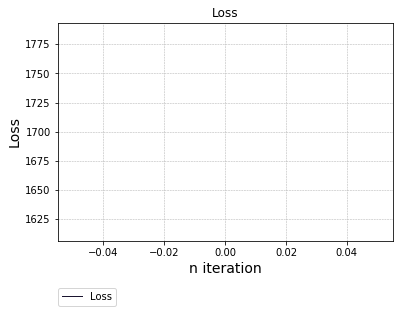

In [94]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Train without using the class

In [95]:
# Solve the same problem, at each iteration the only thing changing are the weights, which are optimized
# TODO why though? wouldn't it make much more sense to train it more times on different problems? isn't this the same as oversampling each training sample?

for _ in range(100):
    net.zero_grad()
    loss = torch.zeros(1)
    prev_total_loss = 0

    batch_size = 1
    u_list = [None] * batch_size
    
    # Sample problem_instances
    problem_idx = np.random.choice(np.arange(nb_problem_instances), batch_size, replace = 0)

    for i in range(batch_size):

        idx = problem_idx[i]
        problem_instance = problem_instances_list[idx]
        
        B_idx = problem_instance.B_idx
        B = problem_instance.B
        f = problem_instance.forcing_term
        initial_u = problem_instance.initial_u
        k = problem_instance.k
        ground_truth = problem_instance.ground_truth
        
        # Compute the solution with the updated weights      
        u_list[i] = im.H_method(net, B_idx, B, f, initial_u, k)

        # Define the loss, CHECK if it is correct wrt paper
        loss = loss + F.mse_loss(ground_truth, u_list[i])
    
   
    """ TODO 
    spectral_radius = TODO
    regularization = 1e10
    if spectral_radius > 1
       loss += regularization
    """

    # Backpropagation
    loss.backward(retain_graph =  False)

    # SGD step
    optim.step()
    
    total_loss = compute_loss(net, problem_instances_list)
    
    # Exit optimization 
    tol = 1e-2
    if total_loss.item() <= tol or total_loss.item() - prev_total_loss < tol:
        break


    # Store lossses for visualization
    losses.append(total_loss.item())
    prev_loss = total_loss.item()

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[-0.2886,  0.3152, -0.2505],
          [ 0.1426, -0.1972, -0.2319],
          [-0.2010, -0.0182,  0.0260]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.1146, -0.2359,  0.1526],
          [-0.0067,  0.2630, -0.0881],
          [-0.1793, -0.2251, -0.0236]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.1289,  0.1859, -0.1396],
          [-0.0827,  0.1516,  0.0015],
          [ 0.0313, -0.1500, -0.0644]]]], requires_grad=True)


Plot the losses

In [96]:
print(losses)

[1699.8089599609375, 304.0516052246094, 304.0514831542969, 304.05145263671875, 304.0513916015625, 304.0512390136719, 304.0508728027344, 304.0507507324219, 304.0505676269531, 304.05047607421875, 304.0503845214844, 304.05029296875, 304.05023193359375, 304.0501403808594, 304.0500793457031, 304.0499572753906, 304.0498352050781, 304.0496520996094, 304.049560546875, 304.0495300292969, 304.0492248535156, 304.0491638183594, 304.0490417480469, 304.0489807128906, 304.0489501953125, 304.04876708984375, 304.0487365722656, 304.0487060546875, 304.0486755371094, 304.04840087890625, 304.04833984375, 304.0483093261719, 304.04827880859375, 304.0482177734375, 304.0479736328125, 304.0478210449219, 304.04779052734375, 304.0476989746094, 304.0476379394531, 304.04754638671875, 304.04742431640625, 304.04736328125, 304.04718017578125, 304.04718017578125, 304.0471496582031, 304.04705810546875, 304.0468444824219, 304.0468444824219, 304.0467834472656, 304.0467224121094, 304.0466613769531, 304.0465087890625, 304.0

final loss is 304.0395202636719


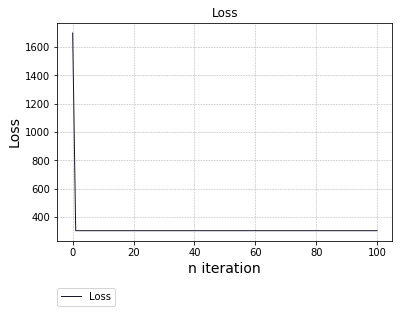

In [97]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter[:], losses[:], color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Test on a bigger grid

In [125]:
N = 50
nb_iters = 2000

B_idx, B = geometries.square_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)
jacoby_pure = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = nb_iters)

In [113]:
loss_to_be_achieved = 1e-3

u_0 = torch.ones(1, 1, N, N)

In [114]:
%%timeit

u_k_old = im.jacobi_method(B_idx, B, f, u_0, k = 1)
loss_of_old = F.mse_loss(gtt, u_k_old)
k_count_old = 1

# old method 
while loss_of_old >= loss_to_be_achieved:
    u_k_old = im.jacobi_method(B_idx, B, f, u_k_old, k = 1)
    loss_of_old = F.mse_loss(gtt, u_k_old)
    k_count_old += 1

1.23 s ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%%timeit

u_k_new = im.H_method(net, B_idx, B, f, u_0, k=1)

loss_new = F.mse_loss(gtt, u_k_new)
k_count_new = 1


# new method

while loss_new >= loss_to_be_achieved:
    u_k_new = im.H_method(net, B_idx, B, f, u_k_new, k=1)
    loss_new = F.mse_loss(gtt, u_k_new)
    k_count_new += 1

4.94 s ± 736 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
print("needed {0} iterations (compared to {1}), ratio: {2}".format(k_count_old, k_count_new, k_count_old/k_count_new))

needed 1 iterations (compared to 1), ratio: 1.0


the loss of the new method is 52.146270751953125, compared to the pure-jacoby one: 40.43793487548828. computed with 2000 iterations


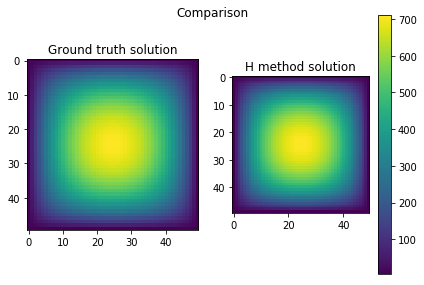

In [118]:
print("the loss of the new method is {0}, compared to the pure-jacoby one: {1}. computed with {2} iterations".format(F.mse_loss(gtt, output), F.mse_loss(gtt, jacoby_pure), nb_iters))

Z_gtt = gtt.view(N,N).numpy() 
Z_output = output.detach().view(N, N).numpy()

fig, axes = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle("Comparison")

im_gtt = axes[0].imshow(Z_gtt)
axes[0].set_title("Ground truth solution")

im_output = axes[1].imshow(Z_output)
axes[1].set_title("H method solution")

fig.colorbar(im_gtt)
fig.tight_layout()

plt.show()

In [121]:
np.mean(Z_gtt - Z_output)

5.732326

Test on L-shape domain

In [132]:
B_idx,B = geometries.l_shaped_geometry(N)

In [134]:
B_idx, B = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

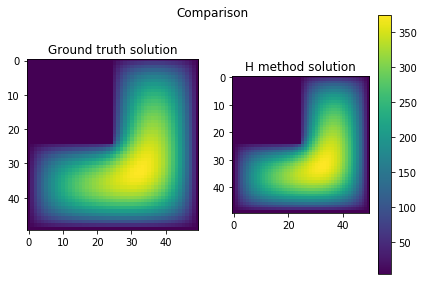

In [137]:
Z_gtt = gtt.view(N,N).numpy() 
Z_output = output.detach().view(N, N).numpy()

fig, axes = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle("Comparison")

im_gtt = axes[0].imshow(Z_gtt)
axes[0].set_title("Ground truth solution")

im_output = axes[1].imshow(Z_output)
axes[1].set_title("H method solution")

fig.colorbar(im_gtt)
fig.tight_layout()

plt.show()